## Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
#import pyarrow.feather as feather
from sklearn.model_selection import train_test_split 

from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.preprocessing import PowerTransformer
#from tensorflow.keras.layers.experimental import preprocessing


# W & B test

In [ ]:
# import wandb
# from wandb.keras import WandbCallback
# !wandb login


## Prepare the data

In [ ]:
# fluxData_df = feather.read_feather('data/fluxData.feather')
# # zernikeData_df = feather.read_feather('data/zernikeData.feather')
# fluxData_df


## import data as h5

In [ ]:
fluxData_df =pd.read_hdf("data/fluxData_df.h5", key="fluxData_df")

zernikeData_df =pd.read_hdf("data/zernikeData_df.h5", key="zernikeData_df")

In [ ]:
# Prepare the training dataset
X = fluxData_df
y = zernikeData_df
x_train, x_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42)


## Box-Cox transform
turned out to be of no effect

In [ ]:
pt = PowerTransformer()

#x_trainTransform = pt.fit_transform(x_train)

## Normalize data
as shown in https://keras.io/guides/preprocessing_layers/#normalizing-numerical-features 

In [ ]:

x_train_norm = (x_train - x_train.mean(axis=0)) / x_train.std(axis=0)
x_train_norm

# Build Model

In [ ]:
from tensorflow import keras
AoModel = keras.Sequential([
     layers.InputLayer(19, name="digits"),
     layers.Dense(2000, activation="relu", name = "Layer1"),
     #keras.layers.Dropout(0.5),
     #keras.layers.BatchNormalization(),
     layers.Dense(1050, activation="relu", name="Layer2"),
     #keras.layers.Dropout(0.5),
     #keras.layers.BatchNormalization(),
     layers.Dense(100, activation="relu", name="Layer3"),
     #keras.layers.BatchNormalization(),
     layers.Dense(9, activation="linear", name="predictions"),

])
keras.utils.plot_model(AoModel, "AoModel.png", show_shapes = True)

## Compile and run model 

In [ ]:
batch_size = 128
epochs = 200
tf.random.set_seed(2021)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1, cooldown= 5)
opt = keras.optimizers.Adam(learning_rate=0.001)
AoModel.compile(loss= keras.losses.MeanSquaredError(),  optimizer=opt, metrics= [tf.keras.metrics.RootMeanSquaredError()])
AoModel.fit(x_train_norm, y_train, batch_size=batch_size, epochs=epochs,validation_split = 0.2, verbose = 2, callbacks=[reduce_lr])

#AoModel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[WandbCallback()])

## Build model with funcitonal API

In [ ]:
NoLayers =4
inputs = keras.Input(shape=(19,))
Layer1 = layers.Dense(2000, activation="relu", name = "Layer1")
x = Layer1(inputs)
x = layers.Dense(1050, activation="relu", name = "Layer2")(x)
x = layers.Dense(1000, activation="relu", name = "Layer3")(x)
if(NoLayers >3):
    x = layers.Dense(100, activation="relu", name = "Layer4")(x)
outputs = layers.Dense(9, name = "Output")(x)
AoFunctionalModel = keras.Model(inputs=inputs, outputs=outputs, name="AOModel")

AoFunctionalModel.summary()

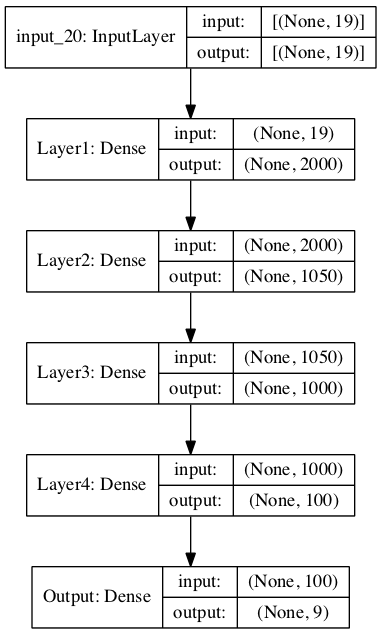

In [43]:
keras.utils.plot_model(AoFunctionalModel, "AoModel.png", show_shapes = True)

## Run Ao funcitonal model

In [ ]:
batch_size = 128
epochs = 200
tf.random.set_seed(2021)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.000001, verbose=1, cooldown= 5)
opt = keras.optimizers.Adam(learning_rate=0.001)
AoFunctionalModel.compile(loss= keras.losses.MeanSquaredError(),  optimizer=opt, metrics= [tf.keras.metrics.RootMeanSquaredError()])
AoFunctionalModel.fit(x_train_norm, y_train, batch_size=batch_size, epochs=epochs,validation_split = 0.2, verbose = 2, callbacks=[reduce_lr])

#AoModel.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[WandbCallback()])